In [1]:
import numpy as np
import pImpactR as impact
from copy import deepcopy as copy
import matplotlib.pyplot as plt
import sys
# np.set_printoptions(formatter={'float': lambda x: format(x, '1.2E')})

In [2]:
nTurn = 1024
npt = 10

nCore_y = 1
nCore_z = 1

NL_c = 0.01
NL_t = 0.4
NL_nu= 0.3
NL_L = 1.8
dTune = 0.0

alfx = np.tan(np.pi*NL_nu)
betx = NL_L/np.sin(2.0*np.pi*NL_nu)

# 1. Preparation

In [3]:
beam, lattice = impact.readInputFile('test_toymodel.in');
beam.nCore_y = nCore_y
beam.nCore_z = nCore_z
beam.distribution.distribution_type = 'ReadFile'
beam.current = 0.0

ke = beam.kinetic_energy
mass = beam.mass
freq = beam.frequency

reading ImpactZ input file (test_toymodel.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done


In [4]:
def normalize(data):
    data[:,1] = (data[:,0]*alfx/np.sqrt(betx) + data[:,1]*np.sqrt(betx))/NL_c
    data[:,3] = (data[:,2]*alfx/np.sqrt(betx) + data[:,3]*np.sqrt(betx))/NL_c
    data[:,0] = data[:,0]/(np.sqrt(betx)*NL_c)
    data[:,2] = data[:,2]/(np.sqrt(betx)*NL_c)
    
def unnormalize(data):
    data[:,1] = (-data[:,0]*alfx + data[:,1])*NL_c/np.sqrt(betx)
    data[:,3] = (-data[:,2]*alfx + data[:,3])*NL_c/np.sqrt(betx)
    data[:,0] = data[:,0]*np.sqrt(betx)*NL_c
    data[:,2] = data[:,2]*np.sqrt(betx)*NL_c

In [5]:
for i in range(len(lattice)-1,0,-1):
    if lattice[i].type == 'write_raw_ptcl':
        lattice.pop(i)
lattice[1].n_sckick = 101
lattice[1].n_map = 100
lattice[1].length = NL_L
lattice[1].strength_t = NL_t
lattice[1].transverse_scale_c = NL_c
lattice[1].tune_advance = NL_nu

lattice[2].tune_advance = dTune
lattice[2].nonlinear_insert_tuneAdvance = NL_nu
lattice[2].nonlinear_insert_length = NL_L

In [6]:
lattice[1]


             length: 1.8 [m]
           n_sckick: 101 [1]
              n_map: 100 [1]
         strength_t: 0.4
 transverse_scale_c: 0.01
        pipe_radius: 10.0 [m]
       tune_advance: 0.3
               type: 'nonlinear_insert'

In [7]:
lattice[0].turns = nTurn

TBT = impact.getElem('TBT')
TBT.file_id = 11111
TBT.pID_begin = 1
TBT.pID_end = npt
lattice.insert(1,TBT)

# prepare particles

In [8]:
# data=np.loadtxt('regular_points.data')
# print(data)
# print(data.shape)

In [20]:
k=0
q_m = beam.multi_charge.q_m[0]
pTest = np.zeros([npt,9])
pTest[:,6] = q_m
pTest[:,-1] = np.arange(1,npt+1)
pTest[:,0] = np.arange(0.3/npt,0.3+0.0001,0.3/npt)
pTest[:,2] = np.arange(0.5/npt,0.5+0.0001,0.5/npt)
# pTest[:,0] = data[0]
# pTest[:,2] = data[1]
beam.n_particles = npt

In [10]:
pTest[-1,0]

0.30000000000000004

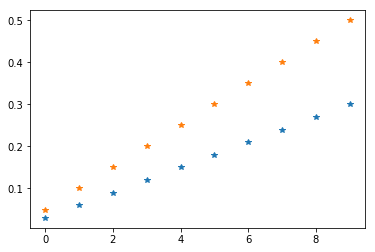

In [11]:
plt.plot(pTest[:,0],'*')
plt.plot(pTest[:,2],'*')

In [23]:
unnormalize(pTest)
impact.writeParticleData(pTest, ke, mass, freq)

In [13]:
impact.writeInputFile(beam,lattice) 
impact.run(beam)

0

In [14]:
iTBT,TBT = impact.readTBT(11111,ke,mass,freq)
print(len(iTBT))
print(TBT.shape)

10
(1024, 6, 10)


In [15]:
X = np.zeros([nTurn,npt],dtype=np.complex64)
Y = np.zeros([nTurn,npt],dtype=np.complex64)
for i in range(nTurn):
    X[i,:] = (TBT[i,0,:] - 1j*(betx*TBT[i,1,:]+alfx*TBT[i,0,:]))/(NL_c*np.sqrt(betx))
    Y[i,:] = (TBT[i,2,:] - 1j*(betx*TBT[i,3,:]+alfx*TBT[i,2,:]))/(NL_c*np.sqrt(betx))

In [16]:
tuneX = np.zeros(npt)
tuneY = np.zeros(npt)
for i in range(npt):
    signal = X[:,i] - X[:,i].mean()
    tuneX[i], amp, dummy = impact.util.naff(1,signal)
    signal = Y[:,i] - Y[:,i].mean()
    tuneY[i], amp, dummy = impact.util.naff(1,signal)

In [17]:
tuneX

array([0.40225006, 0.40121142, 0.39933433, 0.39659422, 0.39357283,
       0.38974435, 0.38568922, 0.38087753, 0.37591125, 0.37027348])

In [18]:
tuneY

array([0.13456293, 0.13483907, 0.13584263, 0.13762593, 0.13966602,
       0.14255981, 0.14630208, 0.1504051 , 0.15535343, 0.16113584])

(0.001, 1000.0)

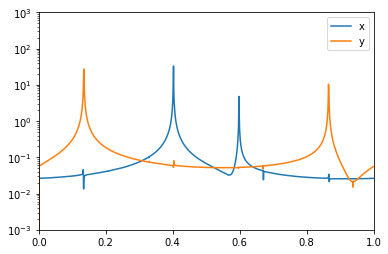

In [19]:
fftx=np.fft.fft(X[:,0] - X[:,0].mean())
ffty=np.fft.fft(Y[:,0] - Y[:,0].mean())
plt.semilogy(np.arange(0,1,1.0/1024),np.abs(fftx))
plt.semilogy(np.arange(0,1,1.0/1024),np.abs(ffty))
plt.legend(('x','y'))
plt.xlim((0,1.0))
plt.ylim((1.0e-3,1.0e3))

In [24]:
normalize(pTest)

In [33]:
import pandas as pd
data = pd.DataFrame(np.array([pTest[:,0],pTest[:,2],tuneX[:],tuneY[:]]).T,
                    columns=['x','y','nux','nuy'],index=range(1,11))
data.to_html('tune.10regular.html')

# Plot

plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.plot(np.real(X[0,:]),tuneX/0.3,'*-')
plt.xlabel('$x_n$');
plt.ylabel(r'$\omega_x$');
plt.subplot(1,3,2)
plt.plot(np.real(X[0,:]),tuneY/0.3,'*-')
plt.xlabel('$x_n$');
plt.ylabel(r'$\omega_y$');
plt.subplot(1,3,3)
plt.plot(np.real(X[0,:]),tuneY/tuneX,'*-')
plt.xlabel('$x_n$');
plt.ylabel(r'$\omega_y/\omega_x$');
plt.tight_layout()
plt.savefig('tune.onArc.png',dpi=180)